In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
import baltic as bt
import json

In [2]:
tree_file = '../data/augur-output/dengue_allBranchEffects_tree.json'
allEffects_err_file = '../data/augur-output/all_effects/dengue_all_predicted_titers.csv'
interseroEffects_err_file = '../data/augur-output/interserotype_effects/dengue_all_predicted_titers.csv'

In [3]:
colors = pickle.load(open('./colors.p', 'rb'))
allEffects_err = pd.read_csv(allEffects_err_file, index_col=None)
interseroEffects_err = pd.read_csv(interseroEffects_err_file, index_col=None)

tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'xvalue'})


Tree height: 0.335580
Tree length: 7.088900
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [4]:
def is_interserotype(node):
    if node.branchType == 'leaf':
        return False
    descendents = node.leaves
    serotypes = [k.split('/')[0] for k in descendents]
    serotypes = [s for s in serotypes if s != 'DENV']
    return len(set(serotypes)) > 1

interserotype_branches = []
for k in tree.Objects:
    if is_interserotype(k):
        interserotype_branches.append(k)
        interserotype_branches += k.children
interserotype_branches = [ k.traits['clade'] for k in interserotype_branches]

In [11]:
def plot_tree(ll, ax, interserotype=False):
    sns.set(style='white',font_scale=1.2)

    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if interserotype==True:
            if 'clade' in k.traits and k.traits['clade'] in interserotype_branches:
                branchWidth=2 ## default branch width
                c = colors['interserotype_effects']
            else:
                branchWidth=1
                c = 'lightgray'
        else:
            branchWidth=2
            c = colors['all_effects']

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            pass
#             s=50 ## tip size can be fixed
#             s=50-30*k.height/ll.treeHeight

#             ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
#             ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.set_yticks([])
    ax.set_xticks([round(x, 2) for x in np.linspace(0, ll.treeHeight, 5)])
    ax.set_ylim(-5,ll.ySpan+7)
    ax.set_xlabel('Substitutions per site')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
def plot_performance(df, ax, c):
    sns.set(style='whitegrid',font_scale=1.2)
    x,y=df['actual'].head(20), df['predicted'].head(20)
    sns.regplot(x,y, ax=ax, scatter_kws={'alpha': 0.3}, color=c)
    fit = linregress(x,y)
    r = fit[2]
    rms_error=np.sqrt( sum([ (actual - predicted)**2 for (actual, predicted) in zip(x,y) ])/len(x))
    ax.text(0.08, 0.9,'r = %.2f'%r, transform=ax.transAxes)
    ax.text(0.08, 0.8, 'rms error = %.2f'%rms_error, transform=ax.transAxes)
    ax.set_xlabel('Actual log2(titer)')
    ax.set_ylabel('Predicted log2(titer)')
    ax.set_xlim(-2, 6)
    ax.set_ylim(-2,6)


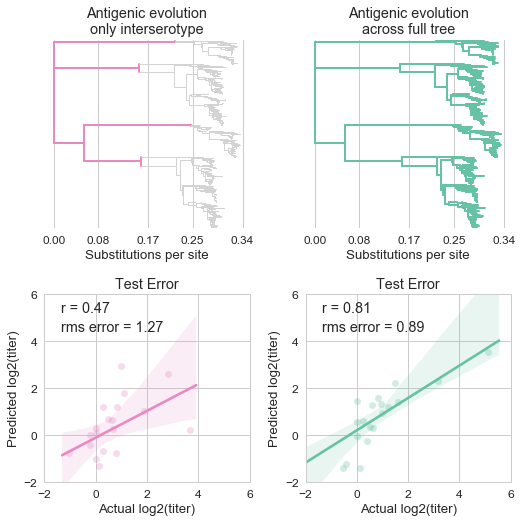

In [12]:
sns.set(font_scale=1.2, style='whitegrid')
fig, axes = plt.subplots(2,2, figsize=(7.5,7.5))

axes[0][0].set_title('Antigenic evolution\nonly interserotype')
plot_tree(tree, ax=axes[0][0], interserotype=True)
axes[1][0].set_title('Test Error')
plot_performance(interseroEffects_err, ax=axes[1][0], c=colors['interserotype_effects'])

axes[0][1].set_title('Antigenic evolution\nacross full tree')
plot_tree(tree, ax=axes[0][1], interserotype=False)
axes[1][1].set_title('Test Error')
plot_performance(allEffects_err, ax=axes[1][1], c=colors['all_effects'])
plt.tight_layout()
plt.savefig('./png/titer_model_performance.png', dpi=300, bbox_inches='tight')